In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

from recommender.testing.custom_metric_utils import create_recommendations_profiles_embeddings, calculate_metric_scores
from recommender.tools.lightfm_utils import LightFMTests

THREADS = 8

## Data loading

In [2]:
DATA_ROOT='../../data'

model = pd.read_pickle('../notebooks_data/warp_model.pkl')

In [3]:
dataset = pd.read_pickle(f'{DATA_ROOT}/dataset.pkl')
item_features = pd.read_pickle(f'{DATA_ROOT}/item_features.pkl')
train_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/train_interactions.npz')
full_test_interactions = scipy.sparse.load_npz(f'{DATA_ROOT}/test_interactions.npz')

In [4]:
full_df = pd.read_csv(f'{DATA_ROOT}/ratings_all_implicit.csv.gz')
train_df = pd.read_csv(f'{DATA_ROOT}/ratings_train_implicit.csv.gz')
test_df = pd.read_csv(f'{DATA_ROOT}/ratings_test_implicit.csv.gz')
games_df = pd.read_json(f'{DATA_ROOT}/bgg_GameItem.jl', lines=True)[[
    'name', 'bgg_id', 'mechanic', 'category', 'complexity',
    'max_players_best', 'min_players_best', 'max_players_rec', 'min_players_rec'
]]

features_names = pd.read_csv(f'{DATA_ROOT}/game_features_names.csv.gz').values.flatten()
game_features = pd.read_csv(f'{DATA_ROOT}/game_features.csv.gz')

In [5]:
users_profiles = pd.read_pickle(f'{DATA_ROOT}/users_profiles.pkl')
test_users_profiles = pd.read_pickle(f'{DATA_ROOT}/test_users_profiles.pkl')
games_profiles = pd.read_pickle(f'{DATA_ROOT}/games_profiles.pkl')

In [6]:
users_profiles.index = users_profiles.index.map(dataset.mapping()[0])
test_users_profiles.index = test_users_profiles.index.map(dataset.mapping()[0])
games_profiles.index = games_profiles.index.map(dataset.mapping()[2])
users_profiles = users_profiles.sort_index()
test_users_profiles = test_users_profiles.sort_index()
games_profiles = games_profiles.sort_index()

In [7]:
users_profiles.values[:, :40] *= 3
test_users_profiles.values[:, :40] *= 3

In [8]:
mechanics_names = features_names[:20]
categories_names = features_names[20:40]

## Users activity

In [9]:
train_counts = train_df['bgg_user_name'].value_counts().rename('train')
test_counts = test_df['bgg_user_name'].value_counts().rename('test')

users_df = pd.concat((train_counts, test_counts), axis=1).dropna()

(array([10128., 24252., 17810.,  8763.,  4989.,  7357.,  1985.,   663.,
          285.,   289.]),
 array([   1,   10,   25,   50,   75,  100,  200,  300,  400,  500, 1000]),
 <BarContainer object of 10 artists>)

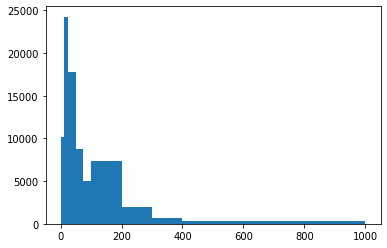

In [10]:
plt.hist(users_df['train'], bins=[1, 10, 25, 50, 75, 100, 200, 300, 400, 500, 1000])

## Utils

In [11]:
def evaluate(min_train, max_train, min_test, max_test):
    users = users_df[(users_df['train'] > min_train)
                     & (users_df['train'] < max_train)
                     & (users_df['test'] > min_test)
                     & (users_df['test'] < max_test)].index.values
    print("Number of chosen users: ", len(users))
    chosen_ratings = test_df[test_df['bgg_user_name'].isin(users)]
    print("Number of ratings of chosen users: ", len(chosen_ratings))
    test_interactions = dataset.build_interactions(
        (
            (val["bgg_user_name"], val["bgg_id"], val["value"])
            for idx, val in chosen_ratings.iterrows()
        )
    )[1]
    print("Test interactions prepared")
    test_class = LightFMTests(model=model,
                              train_df=train_df,
                              dataset=dataset,
                              train_interactions=train_interactions,
                              test_interactions=test_interactions,
                              item_features=item_features)
    precision = test_class.precision_at_k(k=5,
                                          num_threads=THREADS).mean()
    print("Precision calculated: ", precision)
    users_names = np.random.choice(users, size=min(1000, len(users)), replace=False)
    users_id = pd.Series(users_names).map(dataset.mapping()[0]).values
    users_id.sort()
    num_recs = 5
    recommendation_profiles = create_recommendations_profiles_embeddings(
        test_class.get_top_n(num_recs, users_id), num_recs, games_df, categories_names, mechanics_names, 10
    )
    recommendation_profiles.index = recommendation_profiles.index.map(dataset.mapping()[0])
    recommendation_profiles = recommendation_profiles.sort_index()
    score = calculate_metric_scores(recommendation_profiles, test_users_profiles.loc[users_id])
    print("Custom metric score calculated: ", score)
    score = calculate_metric_scores(recommendation_profiles, users_profiles.loc[users_id])
    print("Custom metric score calculated: ", score)
    return precision, score

## Results

In [12]:
precision_scores = []
custom_metric_scores = []
buckets = [(0, 15), (15, 25), (25, 50), (50, 100), (100, 250), (250, 500), (500, np.inf),
           (10, 100), (100, 500), (0, np.inf)]
for min_train, max_train in tqdm(buckets):
    precision_score, custom_metric_score = evaluate(min_train=min_train,
                                                    max_train=max_train,
                                                    min_test=4,
                                                    max_test=np.inf)
    precision_scores.append(precision_score)
    custom_metric_scores.append(custom_metric_score)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of chosen users:  8387
Number of ratings of chosen users:  44440
Test interactions prepared
Precision calculated:  0.14598784


 10%|█         | 1/10 [00:15<02:16, 15.21s/it]

Custom metric score calculated:  [0.72127633 0.94304085 0.32677417 0.77418911 2.76528046]
Custom metric score calculated:  [0.74042643 0.94649511 0.32809552 0.75836452 2.77338159]
Number of chosen users:  11874
Number of ratings of chosen users:  101761
Test interactions prepared
Precision calculated:  0.19435744


 20%|██        | 2/10 [00:33<02:13, 16.73s/it]

Custom metric score calculated:  [0.72261124 0.88201414 0.31950814 0.7836157  2.70774922]
Custom metric score calculated:  [0.7291947  0.88165037 0.31881676 0.7721332  2.70179504]
Number of chosen users:  17057
Number of ratings of chosen users:  263166
Test interactions prepared
Precision calculated:  0.26894534


 30%|███       | 3/10 [00:57<02:22, 20.33s/it]

Custom metric score calculated:  [0.67378818 0.82278732 0.30435582 0.79392088 2.5948522 ]
Custom metric score calculated:  [0.6797871  0.82225996 0.30349657 0.7854321  2.59097573]
Number of chosen users:  13102
Number of ratings of chosen users:  398159
Test interactions prepared
Precision calculated:  0.38845977


 40%|████      | 4/10 [01:26<02:21, 23.64s/it]

Custom metric score calculated:  [0.64819341 0.78326809 0.30207189 0.79063332 2.52416671]
Custom metric score calculated:  [0.64824291 0.78276319 0.30139326 0.78582628 2.51822563]
Number of chosen users:  8515
Number of ratings of chosen users:  549280
Test interactions prepared
Precision calculated:  0.55903697


 50%|█████     | 5/10 [02:01<02:19, 27.92s/it]

Custom metric score calculated:  [0.57574833 0.72949702 0.30002424 0.78525591 2.3905255 ]
Custom metric score calculated:  [0.57585908 0.7279847  0.29959263 0.78306229 2.3864987 ]
Number of chosen users:  1656
Number of ratings of chosen users:  233136
Test interactions prepared
Precision calculated:  0.7379227


 60%|██████    | 6/10 [02:29<01:51, 27.76s/it]

Custom metric score calculated:  [0.52404358 0.69165515 0.30032337 0.77818548 2.29420758]
Custom metric score calculated:  [0.52399534 0.69127484 0.30001019 0.77730041 2.29258078]
Number of chosen users:  307
Number of ratings of chosen users:  89822
Test interactions prepared
Precision calculated:  0.876873


 70%|███████   | 7/10 [02:44<01:11, 23.76s/it]

Custom metric score calculated:  [0.46681256 0.67772003 0.29872597 0.75789983 2.20115839]
Custom metric score calculated:  [0.46770516 0.67811213 0.29845475 0.75759026 2.2018623 ]
Number of chosen users:  52706
Number of ratings of chosen users:  837774
Test interactions prepared
Precision calculated:  0.2608925


 80%|████████  | 8/10 [03:32<01:02, 31.38s/it]

Custom metric score calculated:  [0.66670182 0.8491679  0.31609012 0.78227581 2.61423565]
Custom metric score calculated:  [0.67525254 0.85079195 0.31613022 0.77391158 2.61608629]
Number of chosen users:  10185
Number of ratings of chosen users:  783914
Test interactions prepared
Precision calculated:  0.5883358


 90%|█████████ | 9/10 [04:15<00:35, 35.14s/it]

Custom metric score calculated:  [0.57891531 0.72646879 0.30128319 0.78800021 2.3946675 ]
Custom metric score calculated:  [0.58005084 0.72623936 0.30122698 0.78612872 2.3936459 ]
Number of chosen users:  64832
Number of ratings of chosen users:  1724508
Test interactions prepared
Precision calculated:  0.3130738


100%|██████████| 10/10 [05:34<00:00, 33.41s/it]

Custom metric score calculated:  [0.66585176 0.82878824 0.31139227 0.78290412 2.58893638]
Custom metric score calculated:  [0.66963879 0.82757079 0.31117044 0.77644046 2.58482048]


In [19]:
results = [{"min_train": train_count[0],
            "max_train": train_count[1],
            "precision": precision,
            "custom_metric_score": metric_score[4],
            "categories_score": metric_score[0],
            "mechanics_score": metric_score[1],
            "players_count_score": metric_score[2],
            "complexity_score": metric_score[3]
           } for train_count, precision, metric_score in zip(buckets, precision_scores, custom_metric_scores)
          ]

In [20]:
pd.DataFrame(results)

,min_train,max_train,precision,custom_metric_score,categories_score,mechanics_score,players_count_score,complexity_score
0,0,15.0,0.145988,2.773382,0.740426,0.946495,0.328096,0.758365
1,15,25.0,0.194357,2.701795,0.729195,0.881650,0.318817,0.772133
2,25,50.0,0.268945,2.590976,0.679787,0.822260,0.303497,0.785432
3,50,100.0,0.388460,2.518226,0.648243,0.782763,0.301393,0.785826
4,100,250.0,0.559037,2.386499,0.575859,0.727985,0.299593,0.783062
5,250,500.0,0.737923,2.292581,0.523995,0.691275,0.300010,0.777300
6,500,inf,0.876873,2.201862,0.467705,0.678112,0.298455,0.757590
7,10,100.0,0.260893,2.616086,0.675253,0.850792,0.316130,0.773912
8,100,500.0,0.588336,2.393646,0.580051,0.726239,0.301227,0.786129
9,0,inf,0.313074,2.584820,0.669639,0.827571,0.311170,0.776440
